# Sunpy SDO data

## 1. Prerrequisites

In [176]:
import warnings

from pathlib import Path

import numpy as np

from sunpy.net import Fido, attrs as a
import sunpy.map
from astropy.coordinates import SkyCoord

from astropy import units as u
from astropy.io import fits
from astropy.io.fits.verify import VerifyWarning


import matplotlib.pyplot as plt


## 2. Search the data

In [177]:
print(a.Instrument.hmi)

<sunpy.net.attrs.Instrument(HMI: Helioseismic and Magnetic Imager) object at 0x7c8acd00d950>


In [178]:
from datetime import datetime, timedelta
date = datetime.strptime("2012-07-04T09:54:53Z", "%Y-%m-%dT%H:%M:%SZ")
start_date = date - timedelta(seconds=20)
end_date = date + timedelta(seconds=20)
start_date_str = start_date.strftime("%Y-%m-%dT%H:%M:%SZ")
end_date_str = end_date.strftime("%Y-%m-%dT%H:%M:%SZ")
print(start_date, end_date)

# jsoc_instrument_name = 'hmi.ic_45s'
# band = "continuum"
# results = Fido.search(a.Time(start_date_str, end_date_str),
#             a.jsoc.Series(jsoc_instrument_name),
#             a.jsoc.Segment(band),
#             a.jsoc.Notify("juagudeloo@unal.edu.co"))

instrument = a.Instrument.hmi


hmi_cont = hmi_data["vso"][hmi_data["vso"]["Physobs"] == "intensity"]

download_path = Path("./data/sunpy_images/")
download_path.mkdir(parents=True, exist_ok=True)
# filename = date.strftime("%Y-%m-%dT%H:%M:%SZ") + f"_{jsoc_instrument_name.replace('.', '_').upper()}_{band}.fits"
filename = date.strftime("%Y-%m-%dT%H:%M:%SZ") + f"_{instrument.value.replace('.', '_').upper()}_CONTINUUM.fits"
file_path = download_path / filename

if file_path.exists():
    print(f"File {file_path} already exists. Skipping download.")
else:
    hmi_data = Fido.search(a.Time(start_date_str, end_date_str),
                instrument)
    download_files = Fido.fetch(hmi_cont, path=file_path)


2012-07-04 09:54:33 2012-07-04 09:55:13
File data/sunpy_images/2012-07-04T09:54:53Z_HMI_CONTINUUM.fits already exists. Skipping download.


In [179]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=VerifyWarning)
    amap = sunpy.map.Map(download_files[0])

coord = SkyCoord(100 * u.arcsec, 10*u.arcsec, frame=amap.coordinate_frame)
coord

<SkyCoord (Helioprojective: obstime=2012-07-04T09:55:03.000, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2012-07-04T09:55:03.000, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (0.09346381, 3.280761, 1.52114554e+11)>): (Tx, Ty) in arcsec
    (100., 10.)>

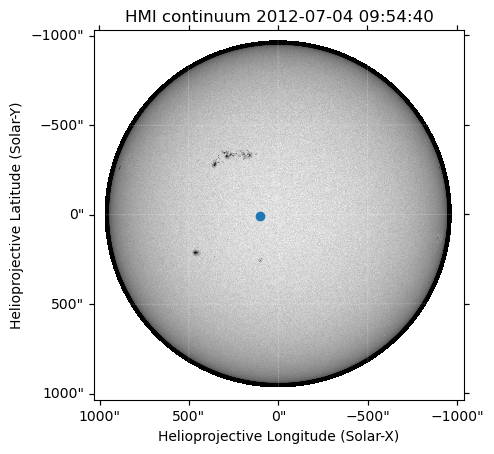

In [180]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(projection=amap)
amap.plot()
ax.plot_coord(coord, 'o')

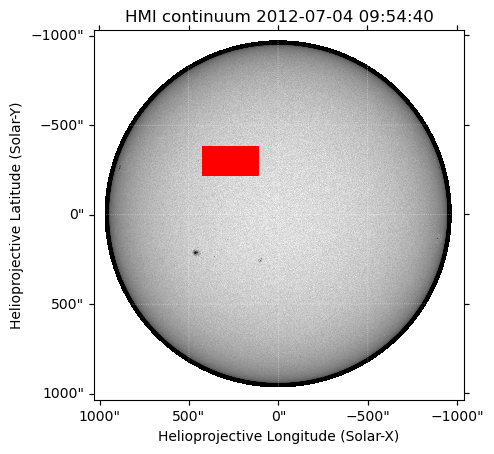

In [181]:
# Define the pixel range
ymin, ymax = 2500, 2800 # rows (y-axis)
xmin, xmax = 1200, 1800  # columns (x-axis)

# Create a grid of pixel coordinates
yy, xx = np.mgrid[ymin:ymax, xmin:xmax]

# Convert pixel coordinates to world coordinates
section_coords = amap.pixel_to_world(xx * u.pixel, yy * u.pixel)

# Plot the map and overlay the section coordinates
fig = plt.figure()
ax = plt.subplot(projection=amap)
amap.plot()
ax.plot_coord(section_coords, '.', color='red', markersize=1)
plt.show()

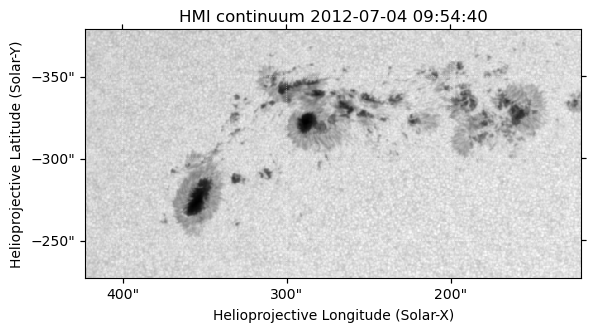

In [182]:
# Define the pixel range
# Convert pixel corners to world coordinates
bottom_left = amap.pixel_to_world(xmin * u.pixel, ymin * u.pixel)
top_right = amap.pixel_to_world((xmax - 1) * u.pixel, (ymax - 1) * u.pixel)

# Extract the submap
submap = amap.submap(bottom_left, top_right=top_right)

# Plot only the submap
fig = plt.figure()
ax = plt.subplot(projection=submap)
submap.plot()
plt.show()

In [195]:
from skimage import io, transform, exposure

directory = Path('/home/juanessao/Documents/Doctorado/Desarrollos/HelioViewer/images/')
images_name = 'paper_image.png'
paper_img = io.imread(directory / images_name, as_gray=True)  # Paper figure
full_data = np.nan_to_num(amap.data, nan=0.0).astype(np.float32)  # Handles signed mag data
if amap.wavelength.unit == 'G': full_data = np.abs(full_data)  # Mag normalization

original_image = cv2.normalize(np.abs(full_data), None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)



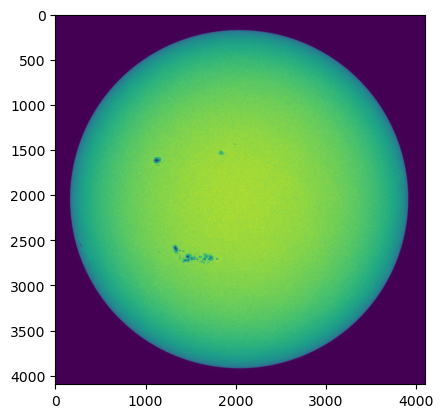

In [196]:
plt.imshow(original_image.astype(np.float32))
plt.savefig('full_normalized_image.png')


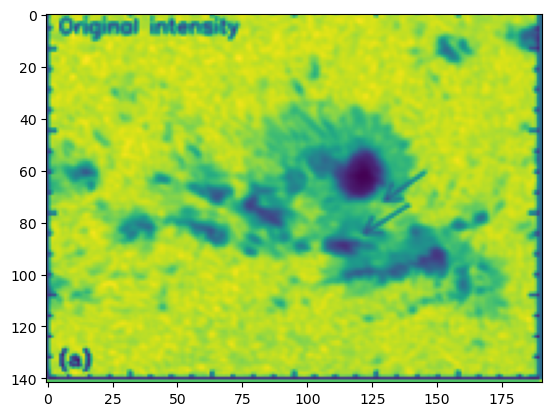

In [197]:
img = full_norm.astype(np.float32)
template = paper_img.copy().astype(np.float32)
plt.imshow(template)

Raw images ready. Paper shape: (142, 191), Original: (4096, 4096)
Using SIFT
Using SIFT
Step 3 complete (SIFT/SIFT): 78 keypoints (paper), 155 (original).
Step 4 complete: 3 good matches (strict ratio=0.65).
Too few good matches.


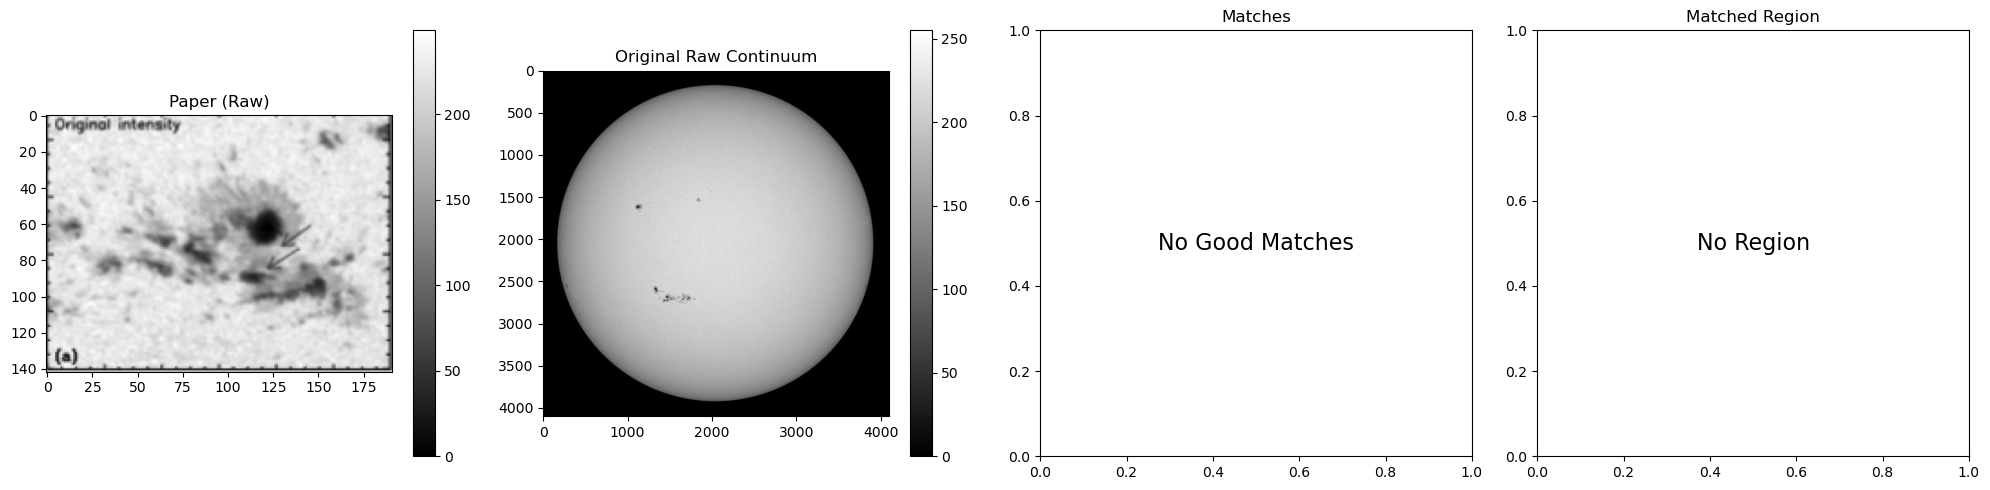

Raw pipeline complete! Check *_raw.jpg files. If still poor → SuperGlue time.


In [200]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import io  # No exposure.equalize_hist!
# Assume 'amap' and 'paper_img'/'original_image' defined upstream

# Step 1: RAW NORMALIZATION (critical fix!)
def preprocess_raw_continuum(amap_data):
    """Raw HMI continuum: abs(mag) -> normalized uint8, NO histeq"""
    data = np.abs(amap_data).astype(np.float32)
    data = np.nan_to_num(data, nan=0.0)
    return cv2.normalize(data, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Your paper image (keep as-is, but raw preprocess)
paper_gray = paper_img if paper_img.dtype == np.uint8 else (paper_img * 255).astype(np.uint8)

# RAW original (skip equalize_hist!)
original_raw = preprocess_raw_continuum(amap.data)

print(f"Raw images ready. Paper shape: {paper_gray.shape}, Original: {original_raw.shape}")

# Step 2: Better denoising (bilateral preserves sunspot edges)
paper_denoised = cv2.bilateralFilter(paper_gray, 9, 75, 75)
original_denoised = cv2.bilateralFilter(original_raw, 9, 75, 75)

# Step 3: SIFT (more robust) + ORB fallback
def detect_features(img):
    """Try SIFT first, fallback to ORB"""
    try:
        sift = cv2.SIFT_create(nfeatures=3000)
        kp, des = sift.detectAndCompute(img, None)
        print("Using SIFT")
        return kp, des, 'SIFT'
    except:
        orb = cv2.ORB_create(nfeatures=5000, scaleFactor=1.2, nlevels=8)
        kp, des = orb.detectAndCompute(img, None)
        print("Using ORB")
        return kp, des, 'ORB'

kp_paper, des_paper, feat_type_paper = detect_features(paper_denoised)
kp_original, des_original, feat_type_original = detect_features(original_denoised)

print(f"Step 3 complete ({feat_type_paper}/{feat_type_original}): "
      f"{len(kp_paper)} keypoints (paper), {len(kp_original)} (original).")

# Step 4: Adaptive matching (stricter ratio test)
bf = cv2.BFMatcher(cv2.NORM_L2 if 'SIFT' in feat_type_paper else cv2.NORM_HAMMING, crossCheck=False)
matches_all = bf.knnMatch(des_paper, des_original, k=2)

# Stricter ratio test (0.7 -> 0.65) to reject text matches
good_matches = [m for m, n in matches_all if m.distance < 0.65 * n.distance]
print(f"Step 4 complete: {len(good_matches)} good matches (strict ratio=0.65).")

# Step 5: RANSAC (tighter threshold for sunspots)
if len(good_matches) > 10:  # Need more for robust fit
    src_pts = np.float32([kp_paper[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp_original[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    M_sim, inlier_mask = cv2.estimateAffinePartial2D(src_pts, dst_pts, 
                                                     method=cv2.RANSAC,
                                                     ransacReprojThreshold=3.0,  # Tighter
                                                     confidence=0.995)  # Higher confidence
    
    num_inliers = np.sum(inlier_mask)
    print(f"Step 5 complete: {num_inliers}/{len(good_matches)} inliers ({num_inliers/len(good_matches):.1%}).")
    
    if M_sim is not None and num_inliers > 15:  # Quality threshold
        h_paper, w_paper = paper_gray.shape
        h_orig, w_orig = original_raw.shape  # Use raw dims
        
        # Color for viz
        paper_color = cv2.cvtColor(paper_gray, cv2.COLOR_GRAY2BGR)
        original_color = cv2.cvtColor(original_raw, cv2.COLOR_GRAY2BGR)  # Raw color
        
        warped_paper = cv2.warpAffine(paper_color, M_sim, (w_orig, h_orig))
        overlay = cv2.addWeighted(original_color, 0.7, warped_paper, 0.3, 0)
        
        # Save
        cv2.imwrite('overlay_result_raw.jpg', overlay)
        cv2.imwrite('warped_paper_raw.jpg', warped_paper)
        
        # Matches viz (inliers only)
        good_inliers = [good_matches[i] for i in range(len(good_matches)) if inlier_mask[i]]
        match_img = cv2.drawMatches(paper_color, kp_paper, original_color, kp_original, 
                                    good_inliers[:50], None,
                                    matchColor=(0,255,0), singlePointColor=(255,0,0),
                                    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        cv2.imwrite('match_visualization_raw.jpg', match_img)
        
        print("RAW Results saved: overlay_result_raw.jpg, etc.")
        print("Similarity matrix M:\n", M_sim)
        
        # Parameters
        cos_theta = M_sim[0,0]; sin_theta = M_sim[1,0]
        scale = np.sqrt(cos_theta**2 + sin_theta**2)
        angle_deg = np.degrees(np.arctan2(sin_theta, cos_theta))
        tx, ty = M_sim[0,2], M_sim[1,2]
        print(f"Scale: {scale:.3f}, Rotation: {angle_deg:.1f}°, Translation: ({tx:.1f}, {ty:.1f}) pix")
        
        match_img_exists = True
        M_sim_final = M_sim
        
    else:
        print("RANSAC failed (low inliers) - try SuperGlue next.")
        match_img_exists = False
        M_sim_final = None
else:
    print("Too few good matches.")
    match_img_exists = False
    M_sim_final = None

# Your rectangle/matched region code (unchanged, using M_sim_final)
if M_sim_final is not None:
    h_paper, w_paper = paper_gray.shape
    corners = np.float32([[0, 0], [w_paper, 0], [w_paper, h_paper], [0, h_paper]]).reshape(-1, 1, 2)
    transformed_corners = cv2.transform(corners, M_sim_final)
    transformed_corners = transformed_corners.astype(int)

    original_with_rect = cv2.cvtColor(original_raw, cv2.COLOR_GRAY2BGR)
    cv2.polylines(original_with_rect, [transformed_corners], isClosed=True, color=(0, 255, 0), thickness=3)
    cv2.imwrite('original_with_rectangle_raw.jpg', original_with_rect)

    # Matched region crop
    x_min, x_max = np.min(transformed_corners[:, 0, 0]), np.max(transformed_corners[:, 0, 0])
    y_min, y_max = np.min(transformed_corners[:, 0, 1]), np.max(transformed_corners[:, 0, 1])
    x_min, y_min = max(x_min, 0), max(y_min, 0)
    x_max, y_max = min(x_max, original_raw.shape[1]), min(y_max, original_raw.shape[0])
    matched_region = original_raw[int(y_min):int(y_max), int(x_min):int(x_max)]
    
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(original_with_rect, cv2.COLOR_BGR2RGB))
    plt.title('Detected Region (Raw Continuum)')
    plt.savefig('detected_region_raw.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Matched region cropped: {matched_region.shape}")
else:
    matched_region = None

# Your 4-panel plot (adapted)
plt.figure(figsize=(20, 5))
plt.subplot(141); plt.imshow(paper_gray, cmap='gray'); plt.title('Paper (Raw)'); plt.colorbar()
plt.subplot(142); plt.imshow(original_raw, cmap='gray'); plt.title('Original Raw Continuum'); plt.colorbar()
plt.subplot(143)
if match_img_exists:
    plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
    plt.title('Inlier Matches (Green)')
else:
    plt.text(0.5, 0.5, 'No Good Matches', ha='center', va='center', fontsize=16)
    plt.title('Matches')
plt.subplot(144)
if matched_region is not None:
    plt.imshow(matched_region, cmap='gray')
    plt.title('Matched AR Region')
    plt.colorbar()
else:
    plt.text(0.5, 0.5, 'No Region', ha='center', va='center', fontsize=16)
    plt.title('Matched Region')

plt.tight_layout()
plt.savefig('keypoints_matches_region_raw.png', dpi=150, bbox_inches='tight')
plt.show()

print("Raw pipeline complete! Check *_raw.jpg files. If still poor → SuperGlue time.")


In [204]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import io
import torch
import kornia as K
import kornia.feature as KF

# Assume 'amap' and 'paper_img' defined upstream (your preprocessing)

device = K.utils.get_cuda_device_if_available('cuda:0') or torch.device('cpu')
print(f"Using device: {device}")

# LightGlue + DISK models
disk = KF.DISK.from_pretrained("depth-conf").eval().to(device)
matcher = KF.LightGlueMatcher('disk').eval().to(device)  # Default adapter

# Raw preprocessing
def preprocess_raw(amap_data):
    data = np.abs(amap_data).astype(np.float32)
    data = np.nan_to_num(data, nan=0.0)
    return cv2.normalize(data, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

paper_gray_uint8 = paper_img if paper_img.dtype == np.uint8 else (paper_img * 255).astype(np.uint8)
original_raw = preprocess_raw(amap.data)

# To LightGlue tensors (RGB [0,1])
def to_lightglue_tensor(img_gray):
    img_rgb = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB).astype(np.float32) / 255.0
    return K.image_to_tensor(img_rgb, keepdim=False).to(device)  # BxCxHxW

img0_t = to_lightglue_tensor(paper_gray_uint8)  # paper
img1_t = to_lightglue_tensor(original_raw)       # original

print(f"LightGlue: {img0_t.shape} vs {img1_t.shape}")

# Extract features + match
with torch.no_grad():  # Faster inference
    feats0 = disk(img0_t)
    feats1 = disk(img1_t)
    corr = matcher({'image0': feats0, 'image1': feats1})

# Parse high-confidence matches
mkpts0 = corr['keypoints0'][0].cpu().numpy()
mkpts1 = corr['keypoints1'][0].cpu().numpy()
mscores = corr['scores'][0].cpu().numpy()

conf_thresh = 0.1
valid = mscores > conf_thresh
src_pts = mkpts0[valid].reshape(-1, 1, 2)
dst_pts = mkpts1[valid].reshape(-1, 1, 2)

num_matches = len(src_pts)
print(f"✅ {num_matches} matches (conf>{conf_thresh})")

if num_matches > 10:
    # Your RANSAC
    M_sim, inlier_mask = cv2.estimateAffinePartial2D(src_pts, dst_pts,
                                                     method=cv2.RANSAC,
                                                     ransacReprojThreshold=3.0,
                                                     confidence=0.995)
    
    num_inliers = np.sum(inlier_mask)
    print(f"✅ RANSAC: {num_inliers}/{num_matches} inliers ({100*num_inliers/num_matches:.1f}%)")
    
    if M_sim is not None:
        # Visualization (your exact code)
        h_paper, w_paper = paper_gray_uint8.shape
        h_orig, w_orig = original_raw.shape
        
        paper_color = cv2.cvtColor(paper_gray_uint8, cv2.COLOR_GRAY2BGR)
        original_color = cv2.cvtColor(original_raw, cv2.COLOR_GRAY2BGR)
        
        warped_paper = cv2.warpAffine(paper_color, M_sim, (w_orig, h_orig))
        overlay = cv2.addWeighted(original_color, 0.7, warped_paper, 0.3, 0)
        
        cv2.imwrite('overlay_lightglue.jpg', overlay)
        cv2.imwrite('warped_paper_lightglue.jpg', warped_paper)
        
        # Matches viz (top 100 valid)
        valid_indices = np.where(valid)[0][:100]
        kpts0_vis = cv2.KeyPoint_convert(mkpts0[valid_indices])
        kpts1_vis = cv2.KeyPoint_convert(mkpts1[valid_indices])
        matches_vis = [cv2.DMatch(i, i, 0) for i in range(len(valid_indices))]
        
        match_img = cv2.drawMatches(paper_color, kpts0_vis, original_color, kpts1_vis, 
                                   matches_vis, None,
                                   flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        cv2.imwrite('matches_lightglue.jpg', match_img)
        
        # Print transform
        print("LightGlue M:\n", M_sim)
        scale = np.sqrt(M_sim[0,0]**2 + M_sim[1,0]**2)
        angle_deg = np.degrees(np.arctan2(M_sim[1,0], M_sim[0,0]))
        print(f"Scale: {scale:.3f}, Rot: {angle_deg:.1f}°, Tx/Ty: {M_sim[0,2]:.1f}/{M_sim[1,2]:.1f}")
        
        # Rectangle (your code)
        corners = np.float32([[0,0],[w_paper,0],[w_paper,h_paper],[0,h_paper]]).reshape(-1,1,2)
        transformed_corners = cv2.transform(corners, M_sim).astype(int)
        original_with_rect = original_color.copy()
        cv2.polylines(original_with_rect, [transformed_corners], True, (0,255,0), 3)
        cv2.imwrite('original_with_rectangle_lightglue.jpg', original_with_rect)
        
        # Matched region
        x_min, x_max = transformed_corners[:,0,0].min(), transformed_corners[:,0,0].max()
        y_min, y_max = transformed_corners[:,0,1].min(), transformed_corners[:,0,1].max()
        x_min, y_min = max(0, int(x_min)), max(0, int(y_min))
        x_max, y_max = min(w_orig, int(x_max)), min(h_orig, int(y_max))
        matched_region = original_raw[y_min:y_max, x_min:x_max]
        print(f"✅ Matched AR: {matched_region.shape}")
        
        M_sim_final = M_sim
        match_img_final = match_img
        
    else:
        print("❌ RANSAC failed.")
        M_sim_final = None
        match_img_final = None
else:
    print("❌ Too few matches.")
    M_sim_final = None
    match_img_final = None

# Your 4-panel plot
plt.figure(figsize=(20, 5))
plt.subplot(141); plt.imshow(paper_gray_uint8, cmap='gray'); plt.title('Paper'); plt.colorbar()
plt.subplot(142); plt.imshow(original_raw, cmap='gray'); plt.title('Raw Continuum'); plt.colorbar()
plt.subplot(143)
if M_sim_final is not None:
    plt.imshow(cv2.cvtColor(match_img_final, cv2.COLOR_BGR2RGB))
    plt.title(f'LightGlue ({num_matches} matches)')
else:
    plt.text(0.5, 0.5, 'No Matches', ha='center', fontsize=16)
    plt.title('Matches')
plt.subplot(144)
if M_sim_final is not None:
    plt.imshow(matched_region, cmap='gray')
    plt.title('Detected AR')
    plt.colorbar()
else:
    plt.text(0.5, 0.5, 'No Region', ha='center', fontsize=16)
    plt.title('Matched Region')

plt.tight_layout()
plt.savefig('lightglue_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("🎉 LightGlue done! Files: overlay_lightglue.jpg, matches_lightglue.jpg, original_with_rectangle_lightglue.jpg")


Using device: cpu


ValueError: Unknown pretrained model: depth-conf

In [206]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import io
import torch
import kornia as K
import kornia.feature as KF

# Your variables: amap, paper_img (assumed defined)
device = K.utils.get_cuda_device_if_available('cuda:0') or torch.device('cpu')
print(f"Using: {device}")

# ✅ CORRECT: DISK "depth" + LightGlue
disk = KF.DISK.from_pretrained("depth").eval().to(device)  # Fixed!
matcher = KF.LightGlueMatcher('disk').eval().to(device)

# Raw preprocess
def preprocess_raw(amap_data):
    data = np.abs(amap_data).astype(np.float32)
    data = np.nan_to_num(data, nan=0.0)
    return cv2.normalize(data, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

paper_gray = paper_img if paper_img.dtype == np.uint8 else (paper_img * 255).astype(np.uint8)
original_raw = preprocess_raw(amap.data)

# Tensors for LightGlue
def to_tensor(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB).astype(np.float32) / 255.0
    t = K.image_to_tensor(img_rgb, keepdim=False).to(device)  # BxCxHxW
    return t

img0_t, img1_t = to_tensor(paper_gray), to_tensor(original_raw)
print(f"Shapes: {img0_t.shape} vs {img1_t.shape}")

# Match!
with torch.no_grad():
    feats0 = disk(img0_t)
    feats1 = disk(img1_t)
    corr = matcher({'image0': feats0, 'image1': feats1})

# High-conf matches
mkpts0 = corr['keypoints0'][0].cpu().numpy()
mkpts1 = corr['keypoints1'][0].cpu().numpy()
scores = corr['scores'][0].cpu().numpy()

valid = scores > 0.1
src_pts = mkpts0[valid].reshape(-1, 1, 2)
dst_pts = mkpts1[valid].reshape(-1, 1, 2)
print(f"✅ {len(src_pts)} LightGlue matches")

# RANSAC (your code)
if len(src_pts) > 10:
    M_sim, inlier_mask = cv2.estimateAffinePartial2D(src_pts, dst_pts, 
                                                     cv2.RANSAC, 3.0, 0.995)
    ninliers = np.sum(inlier_mask)
    print(f"✅ RANSAC: {ninliers}/{len(src_pts)} inliers ({ninliers/len(src_pts)*100:.1f}%)")
    
    if M_sim is not None:
        # Viz
        hp, wp = paper_gray.shape
        ho, wo = original_raw.shape
        paper_c = cv2.cvtColor(paper_gray, cv2.COLOR_GRAY2BGR)
        orig_c = cv2.cvtColor(original_raw, cv2.COLOR_GRAY2BGR)
        
        warped = cv2.warpAffine(paper_c, M_sim, (wo, ho))
        overlay = cv2.addWeighted(orig_c, 0.7, warped, 0.3, 0)
        cv2.imwrite('overlay_lightglue.jpg', overlay)
        
        # Matches (top 100)
        top100 = np.where(valid)[0][:100]
        k0 = cv2.KeyPoint_convert(mkpts0[top100])
        k1 = cv2.KeyPoint_convert(mkpts1[top100])
        mlist = [cv2.DMatch(i,i,0) for i in range(100)]
        match_img = cv2.drawMatches(paper_c, k0, orig_c, k1, mlist, None, flags=0)
        cv2.imwrite('matches_lightglue.jpg', match_img)
        
        # Transform params
        scale = np.sqrt(M_sim[0,0]**2 + M_sim[1,0]**2)
        angle = np.degrees(np.arctan2(M_sim[1,0], M_sim[0,0]))
        print(f"Scale: {scale:.2f}, Angle: {angle:.1f}°, Offset: ({M_sim[0,2]:.0f}, {M_sim[1,2]:.0f})")
        
        # Rectangle (your code)
        corners = np.float32([[0,0],[wp,0],[wp,hp],[0,hp]]).reshape(-1,1,2)
        tcorners = cv2.transform(corners, M_sim).astype(int)
        rect_img = orig_c.copy()
        cv2.polylines(rect_img, [tcorners], True, (0,255,0), 3)
        cv2.imwrite('rect_lightglue.jpg', rect_img)
        
        # Crop AR
        xmin,xmax = tcorners[:,0,0].min(), tcorners[:,0,0].max()
        ymin,ymax = tcorners[:,0,1].min(), tcorners[:,0,1].max()
        xmin,ymin,xmax,ymax = max(0,int(xmin)),max(0,int(ymin)),min(wo,int(xmax)),min(ho,int(ymax))
        ar_crop = original_raw[ymin:ymax, xmin:xmax]
        print(f"✅ AR Crop: {ar_crop.shape}")
        cv2.imwrite('ar_crop_lightglue.jpg', ar_crop)
        
        # Plot
        plt.figure(figsize=(20,5))
        plt.subplot(141); plt.imshow(paper_gray, cmap='gray'); plt.title('Paper')
        plt.subplot(142); plt.imshow(original_raw, cmap='gray'); plt.title('Continuum')
        plt.subplot(143); plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB)); plt.title('Matches')
        plt.subplot(144); plt.imshow(ar_crop, cmap='gray'); plt.title('AR Crop')
        plt.tight_layout(); plt.savefig('lightglue_summary.png', dpi=150); plt.show()
        
        print("🎉 SUCCESS! Files: overlay_lightglue.jpg, matches_lightglue.jpg, rect_lightglue.jpg, ar_crop_lightglue.jpg")
    else:
        print("❌ RANSAC failed")
else:
    print("❌ <10 matches")


Using: cpu
Downloading: "https://raw.githubusercontent.com/cvlab-epfl/disk/master/depth-save.pth" to /home/juanessao/.cache/torch/hub/checkpoints/depth-save.pth


100%|██████████| 4.17M/4.17M [00:00<00:00, 13.0MB/s]


Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/disk_lightglue.pth" to /home/juanessao/.cache/torch/hub/checkpoints/disk_lightglue_v0-1_arxiv-pth


100%|██████████| 45.4M/45.4M [00:02<00:00, 17.2MB/s]


Loaded LightGlue model
Shapes: torch.Size([1, 3, 142, 191]) vs torch.Size([1, 3, 4096, 4096])


ValueError: Input image shape must be divisible by 16 (got torch.Size([1, 3, 142, 191])). This is not inherent to DISK, but to the U-Net architecture used in pretrained models. Please pad if necessary.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import io
import torch
import kornia as K
import kornia.feature as KF

# Your amap, paper_img
device = K.utils.get_cuda_device_if_available('cuda:0') or torch.device('cpu')
print(f"Device: {device}")

# DISK + LightGlue
disk = KF.DISK.from_pretrained("depth").eval().to(device)
matcher = KF.LightGlueMatcher('disk').eval().to(device)

# Raw preprocess
def preprocess_raw(amap_data):
    data = np.abs(amap_data).astype(np.float32)
    data = np.nan_to_num(data, nan=0.0)
    return cv2.normalize(data, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

paper_gray = paper_img if paper_img.dtype == np.uint8 else (paper_img * 255).astype(np.uint8)
original_raw = preprocess_raw(amap.data)

# ✅ PAD TO 16x16 (DISK requirement)
def pad_to_multiple16(img):
    h, w = img.shape
    pad_h = (16 - h % 16) % 16
    pad_w = (16 - w % 16) % 16
    return np.pad(img, ((0, pad_h), (0, pad_w)), mode='constant')

paper_padded = pad_to_multiple16(paper_gray)
original_padded = pad_to_multiple16(original_raw)
print(f"Padded: paper {paper_gray.shape}→{paper_padded.shape}, orig {original_raw.shape}→{original_padded.shape}")

# Tensors
def to_tensor(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB).astype(np.float32) / 255.0
    return K.image_to_tensor(img_rgb, keepdim=False).to(device)

img0_t = to_tensor(paper_padded)
img1_t = to_tensor(original_padded)

# LightGlue magic
with torch.no_grad():
    feats0 = disk(img0_t)  # Now works!
    feats1 = disk(img1_t)
    corr = matcher({'image0': feats0, 'image1': feats1})

# Matches (unpad coords back)
mkpts0 = corr['keypoints0'][0].cpu().numpy() * np.array([paper_padded.shape[1], paper_padded.shape[0]]) / np.array(img0_t.shape[-1::-1])
mkpts1 = corr['keypoints1'][0].cpu().numpy() * np.array([original_padded.shape[1], original_padded.shape[0]]) / np.array(img1_t.shape[-1::-1])
scores = corr['scores'][0].cpu().numpy()

valid = scores > 0.1
src_pts = mkpts0[valid][:1000].reshape(-1, 1, 2)  # Cap for RANSAC speed
dst_pts = mkpts1[valid][:1000].reshape(-1, 1, 2)
print(f"✅ {len(src_pts)} LightGlue matches")

# Your RANSAC + viz
if len(src_pts) > 10:
    M_sim, inlier_mask = cv2.estimateAffinePartial2D(src_pts, dst_pts, 
                                                     cv2.RANSAC, 3.0, 0.995)
    ninliers = np.sum(inlier_mask)
    print(f"✅ RANSAC: {ninliers}/{len(src_pts)} ({ninliers/len(src_pts)*100:.1f}%)")
    
    if M_sim is not None:
        hp, wp = paper_gray.shape
        ho, wo = original_raw.shape
        paper_c = cv2.cvtColor(paper_gray, cv2.COLOR_GRAY2BGR)
        orig_c = cv2.cvtColor(original_raw, cv2.COLOR_GRAY2BGR)
        
        warped = cv2.warpAffine(paper_c, M_sim, (wo, ho))
        overlay = cv2.addWeighted(orig_c, 0.7, warped, 0.3, 0)
        cv2.imwrite('overlay_lightglue.jpg', overlay)
        
        # Top 100 matches
        top100_idx = np.where(valid)[0][:100]
        k0 = cv2.KeyPoint_convert(mkpts0[top100_idx])
        k1 = cv2.KeyPoint_convert(mkpts1[top100_idx])
        matches = [cv2.DMatch(i,i,0) for i in range(100)]
        match_img = cv2.drawMatches(paper_c, k0, orig_c, k1, matches, None, flags=0)
        cv2.imwrite('matches_lightglue.jpg', match_img)
        
        print(f"Scale: {np.sqrt(M_sim[0,0]**2+M_sim[1,0]**2):.3f}")
        print(f"Rotation: {np.degrees(np.arctan2(M_sim[1,0], M_sim[0,0])):.1f}°")
        
        # Rectangle
        corners = np.float32([[0,0],[wp,0],[wp,hp],[0,hp]]).reshape(-1,1,2)
        tc = cv2.transform(corners, M_sim).astype(int)
        rect_img = orig_c.copy()
        cv2.polylines(rect_img, [tc], True, (0,255,0), 3)
        cv2.imwrite('rect_lightglue.jpg', rect_img)
        
        # AR crop
        xmin,xmax = tc[:,0,0].min(), tc[:,0,0].max()
        ymin,ymax = tc[:,0,1].min(), tc[:,0,1].max()
        xmin,ymin,xmax,ymax = max(0,int(xmin)),max(0,int(ymin)),min(wo,int(xmax)),min(ho,int(ymax))
        ar_crop = original_raw[ymin:ymax, xmin:xmax]
        cv2.imwrite('ar_crop_lightglue.jpg', ar_crop)
        print(f"✅ AR: {ar_crop.shape}")
        
        # Plot
        plt.figure(figsize=(20,5))
        plt.subplot(141); plt.imshow(paper_gray, cmap='gray'); plt.title('Paper')
        plt.subplot(142); plt.imshow(original_raw, cmap='gray'); plt.title('Raw')
        plt.subplot(143); plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB)); plt.title('LightGlue Matches')
        plt.subplot(144); plt.imshow(ar_crop, cmap='gray'); plt.title('AR Crop')
        plt.tight_layout()
        plt.savefig('lightglue_final.png', dpi=150)
        plt.show()
        
        print("🎉 ALL FILES SAVED!")
    else:
        print("❌ RANSAC fail")
else:
    print("❌ <10 matches")


Device: cpu
Loaded LightGlue model
Padded: paper (142, 191)→(144, 192), orig (4096, 4096)→(4096, 4096)
